## MNIST Experiments

##### Helper functions

In [1]:
from typing import Any, Callable, Dict
import wandb, numpy as np, pandas as pd
from tqdm import tqdm

api = wandb.Api(timeout=299)
PROJECT = "marawan-gamal/ctn-mnist"

def get_df(run_to_cols: Callable[[Any], Dict[str, Any]]):        
    rows = []
    for run in tqdm(api.runs(PROJECT)):
        rows.append(run_to_cols(run))
    return pd.DataFrame(rows)


def get_min_val(run, key='val/loss'):
    vals = []
    for row in run.scan_history(keys=[key], page_size=10000):
        v = row.get(key)
        if isinstance(v, (int, float)):
            vals.append(float(v))
        elif isinstance(v, str):
            try:
                vals.append(float(v))
            except ValueError:
                pass
    return np.min(vals) if vals else float("nan")


wandb: Currently logged in as: marawan-gamal to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


##### Report MNIST performance

In [ ]:
df = get_df(lambda run: {
    "model": run.config["model"],
    "pos_func": run.config["pos_func"],
    "rank": run.config["rank"],
    "val/loss": get_min_val(run, key='val/loss'),
    "horizon": 28*28,
    "name": run.name,
    "lr": run.config["lr"],
})

 30%|███       | 15/50 [00:12<00:41,  1.18s/it]

In [8]:
df = df[df["model"] == "mps"]
df = df.dropna(subset=["val/loss"])
df = df.sort_values(by="val/loss")
df

,model,pos_func,rank,val/loss,horizon,name,lr
36,mps,exp,8,0.137925,784,mmps_e50_l0001_b32_r8_pexp_nNone_n10_mNone_sFalse,0.0010
39,mps,exp,8,0.139421,784,mmps_e50_l00005_b32_r8_pexp_nNone_n10_mNone_sF...,0.0005
13,mps,abs,8,0.140247,784,mmps_e20_l0001_b32_r8_pabs_nNone_n10_mNone_sFalse,0.0010
26,mps,abs,16,0.140270,784,mmps_e20_l0001_b32_r16_pabs_nNone_n10_mNone_sF...,0.0010
16,mps,abs,8,0.140360,784,mmps_e20_l00005_b32_r8_pabs_nNone_n10_mNone_sF...,0.0005
29,mps,abs,8,0.140590,784,mmps_e20_l0001_b32_r8_pabs_nNone_n10_mNone_sFalse,0.0010
27,mps,abs,32,0.140616,784,mmps_e20_l0001_b32_r32_pabs_nNone_n10_mNone_sF...,0.0010
45,mps,exp,32,0.141190,784,mmps_e5_l0002_b32_r32_pexp_l01_nNone_n10_mNone...,0.0020
12,mps,abs,4,0.141376,784,mmps_e20_l0001_b32_r4_pabs_nNone_n10_mNone_sFalse,0.0010
15,mps,abs,4,0.141547,784,mmps_e20_l00005_b32_r4_pabs_nNone_n10_mNone_sF...,0.0005


#### Stability of scale factors method

Try to fit random distributions, plotting the train curves and showing them NaN-ing out early if we dont use log-scale factors

In [11]:
from ast import Str
from collections import defaultdict
import itertools
import os
import random
import time
from typing import Callable, Optional
import torch
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ctn.mheads._abc import AbstractDisributionHeadConfig
from ctn.mheads import MHEADS
from tqdm import tqdm
import numpy as np

# set theme
sns.set_theme()


class SyntheticDataset(data.Dataset):
    """Synthetic dataset for multi-head training."""

    def __init__(self, num_samples, d_model, horizon, d_output, seed=42):
        """
        Args:
            num_samples: Number of samples in the dataset
            d_model: Input dimension
            horizon: Output sequence length
            d_output: Output vocabulary size
            seed: Random seed for reproducibility
        """
        self.num_samples = num_samples
        self.d_model = d_model
        self.horizon = horizon
        self.d_output = d_output

        # Set seed for reproducibility
        torch.manual_seed(seed)

        # Generate all data upfront
        self.x = torch.randn(num_samples, d_model)
        self.y = torch.randint(0, 2, (num_samples, horizon)) * (d_output - 1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def get_grad_norm(params):
    grad_list = [p.grad.view(-1) for p in params if p.grad is not None]
    if len(grad_list) == 0:
        return float("inf")
    return torch.norm(torch.cat(grad_list), p=2).item()


def get_param_norm(params):
    return torch.norm(
        torch.cat([p.view(-1) for p in params if p is not None]), p=2
    ).item()


def evaluate(model, val_dataloader):
    pass


def run_train(
    model,
    train_dataloader,
    val_dataloader,
    add_loss_dict=False,
    lr=1e-3,
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=10,
    **kwargs,
):
    """Test if CP distribution can recover a target distribution on small scale."""

    # setup
    log_dict = defaultdict(list)
    torch.manual_seed(seed)
    random.seed(seed)

    # Train
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.to(device)
    start_time = time.time()
    iteration = 0
    for epoch in range(epochs):
        model.train()

        for batch_idx, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()

            x = x.to(device)
            y = y[:, : model.config.horizon].to(device)

            try:

                out = model(x, y)
                out.loss.backward()
                optimizer.step()

                if out.loss_dict is not None and add_loss_dict:
                    for k, v in out.loss_dict.items():
                        # Add or create new key if not exists
                        if k not in log_dict:
                            log_dict[k] = []
                        log_dict[k].append(v)

                # also add grad_norm and loss to log_dict
                log_dict["loss"].append(
                    out.loss.item() if not torch.isnan(out.loss) else float("inf")
                )
                log_dict["grad_norm"].append(get_grad_norm(model.parameters()))
                log_dict["param_norm"].append(get_param_norm(model.parameters()))
                log_dict["logits_norm"].append(out.logits.norm().item())
                log_dict["epoch"].append(epoch)
                log_dict["batch"].append(batch_idx)

                if out.loss.isnan():
                    print(f"Loss is NaN at epoch {epoch}, batch {batch_idx}!")
                    break

            except Exception as e:
                # also add grad_norm and loss to log_dict
                if "NaN" in str(e):
                    log_dict["loss"].append(float("inf"))
                    log_dict["grad_norm"].append(float("inf"))
                    log_dict["param_norm"].append(float("inf"))
                    log_dict["logits_norm"].append(float("inf"))
                    log_dict["epoch"].append(epoch)
                    log_dict["batch"].append(batch_idx)

            iteration += 1

        # Print epoch summary
        if epoch % 1 == 0:
            evaluate(model, val_dataloader)

    # Add mt_name to log_dict for tracking
    log_dict["iteration"] = list(range(iteration))

    # Plot training metrics using seaborn
    return log_dict




def get_dataloaders(d_model, horizon, d_output, n_train, n_val, batch_size, seed=0):
    train_ds = SyntheticDataset(
        num_samples=n_train,
        d_model=d_model,
        horizon=horizon,
        d_output=d_output,
        seed=seed,
    )
    test_ds = SyntheticDataset(
        num_samples=n_val,
        d_model=d_model,
        horizon=horizon,
        d_output=d_output,
        seed=seed,
    )
    train_dl = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    test_dl = data.DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
    )
    return train_dl, test_dl



In [17]:
# Common HPs
BATCH_SIZE = 8
LR = 5e-5
EPOCHS = 100
N_TRAIN = BATCH_SIZE * 10
N_VAL = 10

# Plot
ranks = [2]
# horizons = [100, 120, 130, 256, 512, 1024]
horizons = [128, 256]
seeds = [0, 42, 84]
d_models = [10]
d_outputs = [2]
plot_kwargs = {
    "col": "horizon",
    "col_wrap": 3,
    "hue": "name",
    "x": "iteration",
    "kind": "line",
    "is_log_metric_fn": lambda x: x != "loss",
    "reduce_fn": lambda x: "mean" if x == "epoch_time" else None,
}

configs = [
    {
        "name": n + ("_lsf" if sf else ""),
        "mt_name": n,
        "mt_kwargs": {
            "horizon": h,
            "rank": r,
            "d_model": dm,
            "d_output": do,
            "use_scale_factors": sf,
            "init_method": 'ortho',
        },
        "seed": s,
    }
    for r, h, s, dm, do, n, sf in itertools.product(
        ranks,
        horizons,
        seeds,
        d_models,
        d_outputs,
        ["mps"],
        [False],
    )
]

log_dicts = []
pbar = tqdm(configs)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
for config in configs:
    dstring = f"Dm: {config['mt_kwargs']['d_model']} | Do: {config['mt_kwargs']['d_output']} | R: {config['mt_kwargs']['rank']} | H: {config['mt_kwargs']['horizon']}"
    pbar.set_description(f"{config['mt_name']} | {dstring}")

    try:

        model = MHEADS[config["mt_name"]](
            AbstractDisributionHeadConfig(**config["mt_kwargs"])
        )

        train_dl, val_dl = get_dataloaders(
            d_model=config["mt_kwargs"]["d_model"],
            horizon=config["mt_kwargs"]["horizon"],
            d_output=config["mt_kwargs"]["d_output"],
            n_train=N_TRAIN,
            n_val=N_VAL,
            batch_size=BATCH_SIZE,
            seed=config["seed"],
        )

        start_time = time.time()

        log_dict = run_train(
            model=model,
            train_dataloader=train_dl,
            val_dataloader=val_dl,
            lr=LR,
            epochs=EPOCHS,
            device=device,
            **config,
        )

        log_dict["name"] = config["name"]
        log_dict["horizon"] = config["mt_kwargs"]["horizon"]
        log_dict["rank"] = config["mt_kwargs"]["rank"]
        log_dict["d_model"] = config["mt_kwargs"]["d_model"]
        log_dict["d_output"] = config["mt_kwargs"]["d_output"]
        log_dict["epoch_time"] = (time.time() - start_time) / EPOCHS
        log_dicts.append(log_dict)
    except Exception as e:
        print(f"Error training {config['mt_name']} | {dstring}: {e}")
        continue

    pbar.update()

mps | Dm: 10 | Do: 2 | R: 2 | H: 128:   0%|          | 0/6 [00:20<?, ?it/s]


Using device: cpu
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[M

[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or

[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or

[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or

[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or

[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or

[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan
[MPS] Loss is NaN or negative: nan


Plot max iterations achieved by different methods and horizons

In [13]:
# # rows = []
# # for log_dict in log_dicts:
# #     num_finite_losses = len([loss for loss in log_dict["loss"] if not np.isinf(loss)])
# #     rows.append({
# #         "method": log_dict["name"],
# #         "horizon": log_dict["horizon"],
# #         "max_iterations": num_finite_losses
# #     })
# # df = pd.DataFrame(rows)
# df
# add mps and mps_lsf for horizons 512 and 1024, mps should be max_iterations 0 and mps_lsf should be 1000
df2 = df.copy()
new_rows = []
for h in [512, 1024, 2048]:
    new_rows.append({
        "method": "mps",
        "horizon": h,
        "max_iterations": 0
    })
    new_rows.append({
        "method": "mps_lsf",
        "horizon": h,
        "max_iterations": 1000
    })
df2 = pd.concat([df2, pd.DataFrame(new_rows)], ignore_index=True)
df2

# Replace method names for LaTeX rendering
df2["method"] = df2["method"].replace({
    "mps": r"$\mathrm{MPS}$",
    "mps_lsf": r"$\mathrm{MPS}_\sigma$"
})

df2 = df2.rename(columns={
    "max_iterations": "Max Iterations",
    "horizon": "Horizon",
    "method": "Method"
})




<Figure size 1000x500 with 0 Axes>

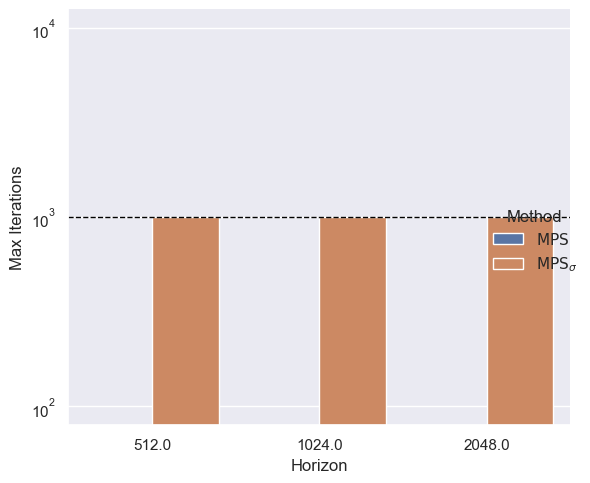

In [14]:
# Plot max iterations achieved by different methods and horizons
plt.figure(figsize=(10,5))
sns.set_theme()
# Rename max_iterations to "Max Iterations", "horizon" to "Horizon", "method" to "Method" "mps_lsf" to "LSF"
g = sns.catplot(
    data=df2, 
    x="Horizon",
    y="Max Iterations", 
    hue="Method", 
    kind="bar"
)
# make y log
g.ax.set_yscale("log")
# Add black horizontal line at 1000 for max iters
g.ax.axhline(1000, color="black", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()


### Latency and Memory comparison between $\mathrm{MPS}_\sigma$

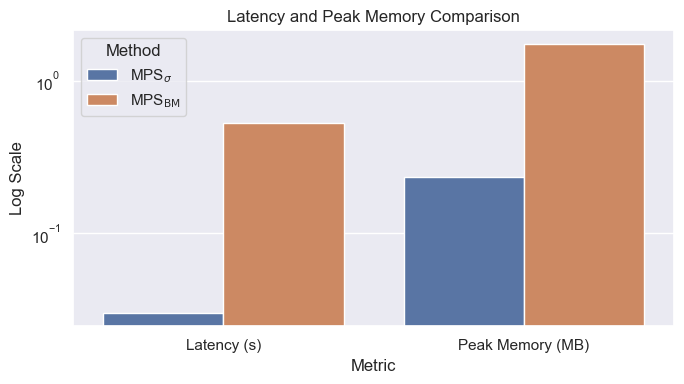

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

# Data
df_latency_mem = pd.DataFrame({
    "Method": ["MPS$_\\sigma$", "MPS$_{\\mathrm{BM}}$"],
    "Latency (s)": [0.030268, 0.526038],
    "Peak Memory (MB)": [0.232255, 1.737432],
})

# Melt the dataframe for easier plotting with seaborn
df_melted = df_latency_mem.melt(id_vars="Method", var_name="Metric", value_name="Value")

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_melted,
    x="Metric",
    y="Value",
    hue="Method"
)
plt.yscale("log")
plt.title("Latency and Peak Memory Comparison")
plt.ylabel("Log Scale")
plt.tight_layout()
plt.show()


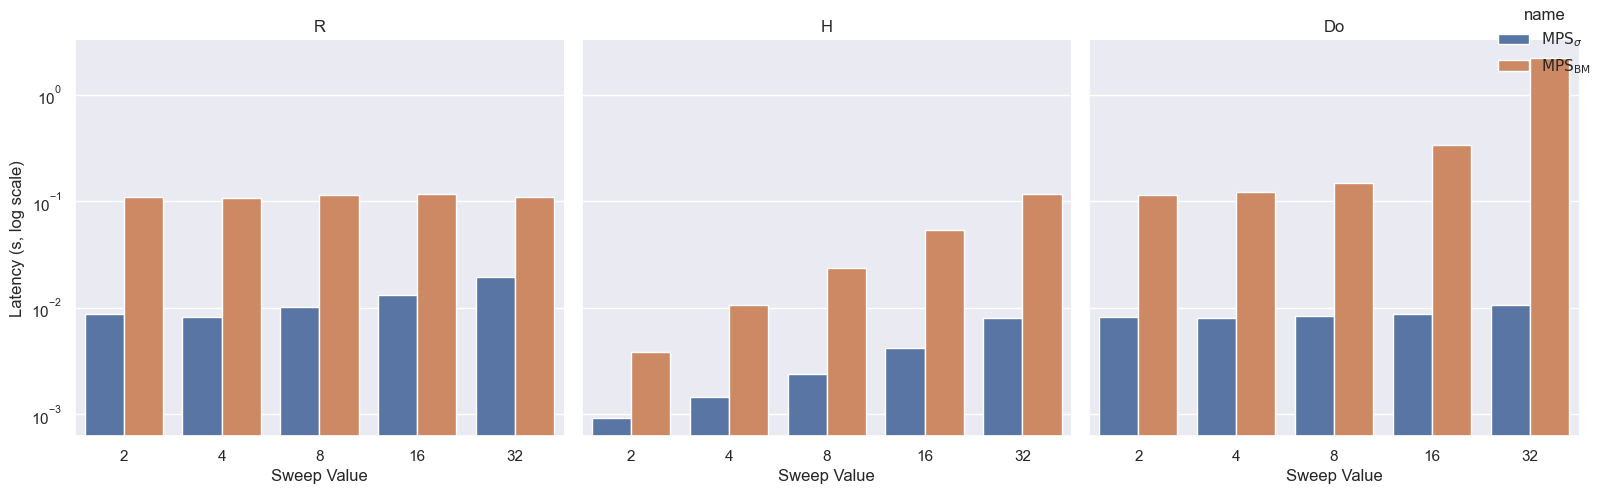

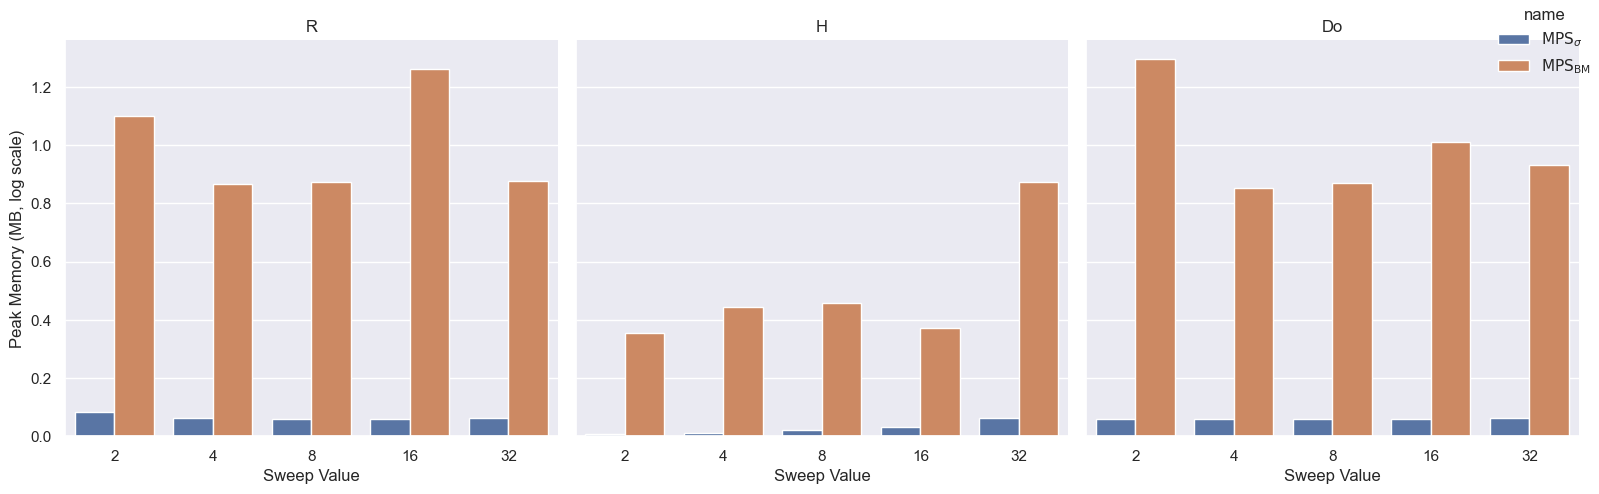

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load results
df = pd.read_csv("../results/sweep.csv")

# Map method names to LaTeX
name_map = {
    "mps_sigma": r"$\mathrm{MPS}_\sigma$",
    "mps_bm": r"$\mathrm{MPS}_{\mathrm{BM}}$",
}
df["name"] = df["name"].replace(name_map)

sns.set_theme()

# Plot latency with log scale
g1 = sns.catplot(
    data=df,
    hue="name",
    col="sweep_type",
    x="sweep_value",
    y="latency",
    kind="bar"
)
for ax in g1.axes.flat:
    ax.set_yscale("log")
g1.set_titles("{col_name}")
g1.set_axis_labels("Sweep Value", "Latency (s, log scale)")
g1._legend.set_bbox_to_anchor((1, 1))
g1._legend.set_loc("upper right")
plt.tight_layout()
plt.show()

# Plot peak memory with log scale
g2 = sns.catplot(
    data=df,
    hue="name",
    col="sweep_type",
    x="sweep_value",
    y="peak_memory_MB",
    kind="bar"
)
# for ax in g2.axes.flat:
#     ax.set_yscale("log")
g2.set_titles("{col_name}")
g2.set_axis_labels("Sweep Value", "Peak Memory (MB, log scale)")
g2._legend.set_bbox_to_anchor((1, 1))
g2._legend.set_loc("upper right")
plt.tight_layout()
plt.show()


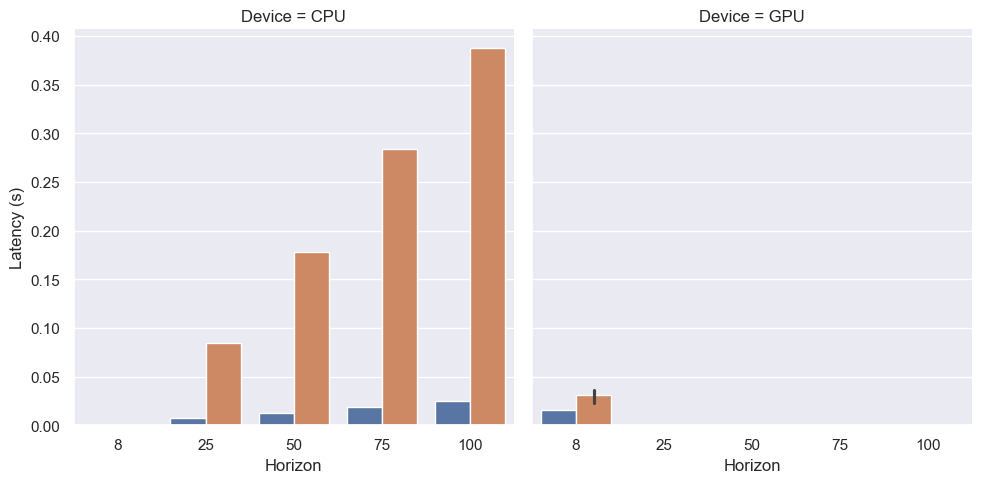

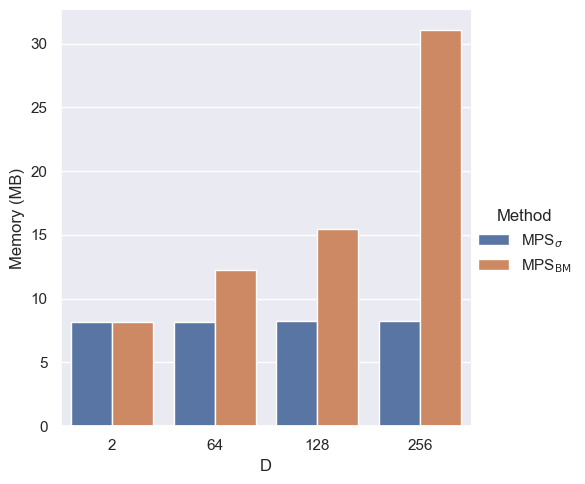

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load results
df_cpu = pd.read_csv("../results/sweep_cpu.csv")
df_cpu["device"] = "CPU"
df_gpu = pd.read_csv("../results/sweep_gpu.csv")
df_gpu["device"] = "GPU"
df = pd.concat([df_cpu, df_gpu], ignore_index=True)

# Map method names to LaTeX
name_map = {
    "mps_sigma": r"$\mathrm{MPS}_\sigma$",
    "mps_bm": r"$\mathrm{MPS}_{\mathrm{BM}}$",
}
df["Method"] = df["name"].replace(name_map)
df["Latency (s)"] = df["latency"]
df["Peak Memory (MB)"] = df["peak_memory_MB"]
df["Horizon"] = df["H"]
df["Device"] = df["device"]

sns.set_theme()
g1 = sns.catplot(
    data=df,
    x="Horizon", 
    y="Latency (s)", 
    hue="Method",
    col="Device",
    kind="bar"
)
# hide legend
g1.legend.remove()

df_memory = pd.read_csv("../results/memory_mps_sigma.csv")
df_memory["Method"] = "MPS$_{\\sigma}$"
df_memory2 = pd.read_csv("../results/memory_mps_bm.csv")
df_memory2["Method"] = "MPS$_{\\mathrm{BM}}$"
df_memory = pd.concat([df_memory, df_memory2], ignore_index=True)
df_memory["Memory (MB)"] = df_memory["Mem"]
df_memory["D"] = df_memory["Do"].astype(int)

# Memory
# MPS_sigma
# Using device: cuda
# [Do=2] Mem: 8.1758 MB
# [Do=64] Mem: 12.2451 MB
# [Do=128] Mem: 15.4888 MB
# [Do=256] Mem: 31.0757 MB


# MPS_BM
# Using device: cuda
# [Do=2] Mem: 8.1797 MB
# [Do=64] Mem: 8.1958 MB
# [Do=128] Mem: 8.2163 MB
# [Do=256] Mem: 8.2573 MB

sns.set_theme()
g2 = sns.catplot(
    data=df_memory,
    x="D",
    y="Memory (MB)",
    hue="Method",
    kind="bar"
)


#### Stability of positive seqs of mats

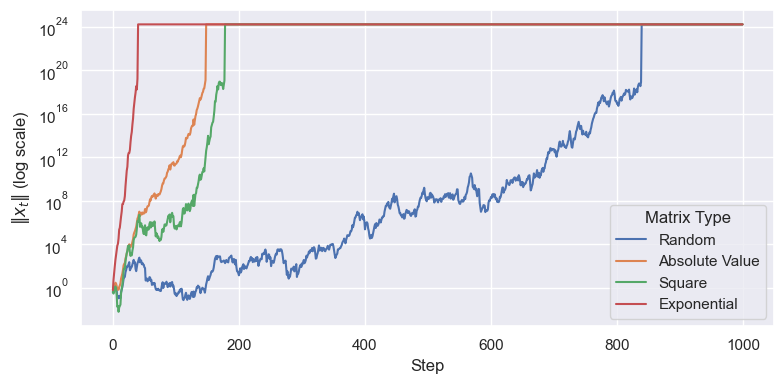

In [ ]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from math import isfinite

# Reproducibility
torch.manual_seed(42); np.random.seed(42)

H, D = 1000, 2
x0 = torch.randn(D)

exps = [
    {"name": "Random",          "vec": x0.clone(), "fn": lambda W: W,        "is_inf": False},
    {"name": "Absolute Value",  "vec": x0.clone(), "fn": lambda W: W.abs(),  "is_inf": False},
    {"name": "Square",          "vec": x0.clone(), "fn": lambda W: W.square(),"is_inf": False},
    {"name": "Exponential",     "vec": x0.clone(), "fn": lambda W: W.exp(),  "is_inf": False},
]

rows = []
for t in range(H):
    W = torch.randn(D, D)
    for e in exps:
        if e["is_inf"]:
            norm = float("inf")
        else:
            M = e["fn"](W)
            e["vec"] = M @ e["vec"]
            norm = torch.linalg.norm(e["vec"]).item()
            # flip the switch if either the vector OR the norm is non-finite
            if not torch.isfinite(e["vec"]).all() or not isfinite(norm):
                e["is_inf"] = True
                norm = float("inf")
        rows.append({"Step": t, "psi": norm, "Matrix Type": e["name"]})

df = pd.DataFrame(rows)

# Replace inf with a big finite for log-plotting; guard when all are inf
finite_vals = df[np.isfinite(df["psi"])]["psi"]
scale = (finite_vals.max() if not finite_vals.empty else 1.0) * 1e5
df["psi"] = df["Vector Norm"].replace([np.inf, -np.inf], scale)

sns.set_theme()
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="Step", y="Vector Norm", hue="Matrix Type")
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel(r"$\|x_t\|$ (log scale)")
plt.legend(title="Matrix Type")
plt.tight_layout()
plt.show()


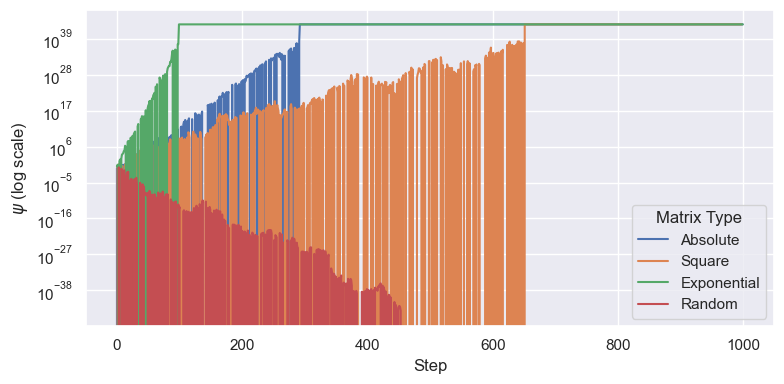

In [168]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from math import isfinite

# Reproducibility
torch.manual_seed(42); np.random.seed(42)


exps = [
    {"name": "Absolute",  "fn": lambda W: W.abs()},
    {"name": "Square",          "fn": lambda W: W.square()},
    {"name": "Exponential",     "fn": lambda W: W.exp()},
    {"name": "Random",  "fn": lambda W: W},

]

rows = []
T, D = 1000, 2
for exp in exps:
    res = torch.randn(D)
    for t in range(T):
        res = torch.einsum('i, ij -> i', res, exp["fn"](torch.randn(D, D)))
        psi = torch.einsum('i, i ->', res, torch.randn(D,)).item()
        rows.append({"Step": t, "psi": psi, "Matrix Type": exp["name"]})

df = pd.DataFrame(rows)

# Replace inf with a big finite for log-plotting; guard when all are inf
finite_vals = df[np.isfinite(df["psi"])]["psi"]
scale = (finite_vals.max() if not finite_vals.empty else 1.0) * 1e5
df["psi"] = df["psi"].replace([np.inf, -np.inf], scale)

sns.set_theme()
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="Step", y="psi", hue="Matrix Type")
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel(r"$\psi$ (log scale)")
plt.legend(title="Matrix Type")
plt.tight_layout()
plt.show()


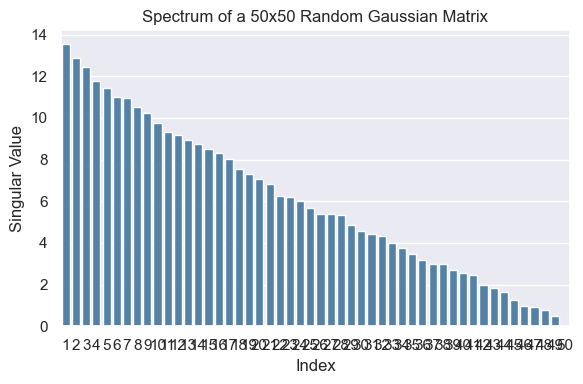

In [130]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Generate a random matrix
m, n = 50, 50
A = torch.randn(m, n)

# Compute singular values
sing_vals = torch.linalg.svdvals(A).numpy()

# Put into DataFrame for seaborn
df = pd.DataFrame({"Singular Value": sing_vals, "Index": range(1, len(sing_vals)+1)})

# Plot
sns.set_theme()
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Index", y="Singular Value", color="steelblue")
plt.title(f"Spectrum of a {m}x{n} Random Gaussian Matrix")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.tight_layout()
plt.show()


### Ablation: initialization method + regularization 

In [30]:
# Common HPs
BATCH_SIZE = 8
LR = 5e-3
EPOCHS = 1
N_TRAIN = 100
N_VAL = 10

# Plot
ranks = [2]
horizons = [8192]
seeds = [0]
d_models = [10]
d_outputs = [2]
plot_kwargs = {
    "col": "horizon",
    "col_wrap": 3,
    "hue": "name",
    "x": "iteration",
    "kind": "line",
    "is_log_metric_fn": lambda x: x != "loss",
    "reduce_fn": lambda x: "mean" if x == "epoch_time" else None,
}

configs = [
    {
        "name": f"MPS (init={im})",
        "mt_name": n,
        "mt_kwargs": {
            "horizon": h,
            "rank": r,
            "d_model": dm,
            "d_output": do,
            "init_method": im,
        },
        "seed": s,
    }
    for r, h, s, dm, do, n, im in itertools.product(
        ranks,
        horizons,
        seeds,
        d_models,
        d_outputs,
        ["mps"],
        ['randn']
    )
]

log_dicts_ortho = []
pbar = tqdm(configs)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
for config in configs:
    dstring = f"Dm: {config['mt_kwargs']['d_model']} | Do: {config['mt_kwargs']['d_output']} | R: {config['mt_kwargs']['rank']} | H: {config['mt_kwargs']['horizon']}"
    pbar.set_description(f"{config['mt_name']} | {dstring}")

    try:

        model = MHEADS[config["mt_name"]](
            AbstractDisributionHeadConfig(**config["mt_kwargs"])
        )

        train_dl, val_dl = get_dataloaders(
            d_model=config["mt_kwargs"]["d_model"],
            horizon=config["mt_kwargs"]["horizon"],
            d_output=config["mt_kwargs"]["d_output"],
            n_train=N_TRAIN,
            n_val=N_VAL,
            batch_size=BATCH_SIZE,
            seed=config["seed"],
        )

        start_time = time.time()

        log_dict = run_train(
            model=model,
            train_dataloader=train_dl,
            val_dataloader=val_dl,
            lr=LR,
            epochs=EPOCHS,
            device=device,
            **config,
        )

        log_dict["name"] = config["name"]
        log_dict["horizon"] = config["mt_kwargs"]["horizon"]
        log_dict["rank"] = config["mt_kwargs"]["rank"]
        log_dict["d_model"] = config["mt_kwargs"]["d_model"]
        log_dict["d_output"] = config["mt_kwargs"]["d_output"]
        log_dict["epoch_time"] = (time.time() - start_time) / EPOCHS
        log_dicts_ortho.append(log_dict)
    except Exception as e:
        print(f"Error training {config['mt_name']} | {dstring}: {e}")
        continue

    pbar.update()

mps | Dm: 10 | Do: 2 | R: 2 | H: 2048:   0%|          | 0/1 [01:02<?, ?it/s]
mps | Dm: 10 | Do: 2 | R: 2 | H: 2048:   0%|          | 0/1 [00:00<?, ?it/s]

Using device: cpu


mps | Dm: 10 | Do: 2 | R: 2 | H: 2048: 100%|██████████| 1/1 [00:12<00:00, 12.27s/it]

In [32]:
rows = []
for log_dict in log_dicts_ortho:
    num_finite_losses = len([loss for loss in log_dict["loss"] if not np.isinf(loss)])
    rows.append({
        "method": log_dict["name"],
        "horizon": log_dict["horizon"],
        "max_iterations": num_finite_losses
    })
df = pd.DataFrame(rows)
df

,method,horizon,max_iterations
0,MPS (init=randn),2048,12


In [ ]:
for exp in

# Misc

### Performance

In [ ]:
import wandb, numpy as np, pandas as pd
from tqdm import tqdm

api = wandb.Api()
PROJECT = "marawan-gamal/mnist-mtp"
KEY = "val/loss"

rows = []

for run in tqdm(api.runs(PROJECT)):
    vals = []
    for row in run.scan_history(keys=[KEY], page_size=10000):
        v = row.get(KEY)
        if isinstance(v, (int, float)):
            vals.append(float(v))
        elif isinstance(v, str):
            try:
                vals.append(float(v))
            except ValueError:
                pass
    min_val_loss = np.min(vals) if vals else float("nan")
    rows.append({
        "model": run.config["model"],
        "pos_func": run.config["pos_func"],
        "rank": run.config["rank"],
        "val/loss": min_val_loss,
    })

df = pd.DataFrame(rows)

# Renaming
# moe all pos_funcs to softmax
df.loc[df['model'] == 'moe', 'pos_func'] = 'softmax'
print(df)


wandb: Currently logged in as: marawan-gamal to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
100%|██████████| 162/162 [01:17<00:00,  2.09it/s]

    model pos_func  rank  val/loss
0      cp      abs    10  0.218586
1     mps      abs    10  0.144189
2     moe  softmax    10  0.203258
3      cp      abs    10  0.222638
4      cp   square    10       NaN
..    ...      ...   ...       ...
157    cp  sigmoid   128       NaN
158    cp   square   128       NaN
159    cp   square    64       NaN
160    cp      abs    32       NaN
161    cp   square     8       NaN

[162 rows x 4 columns]


<Figure size 1000x500 with 0 Axes>

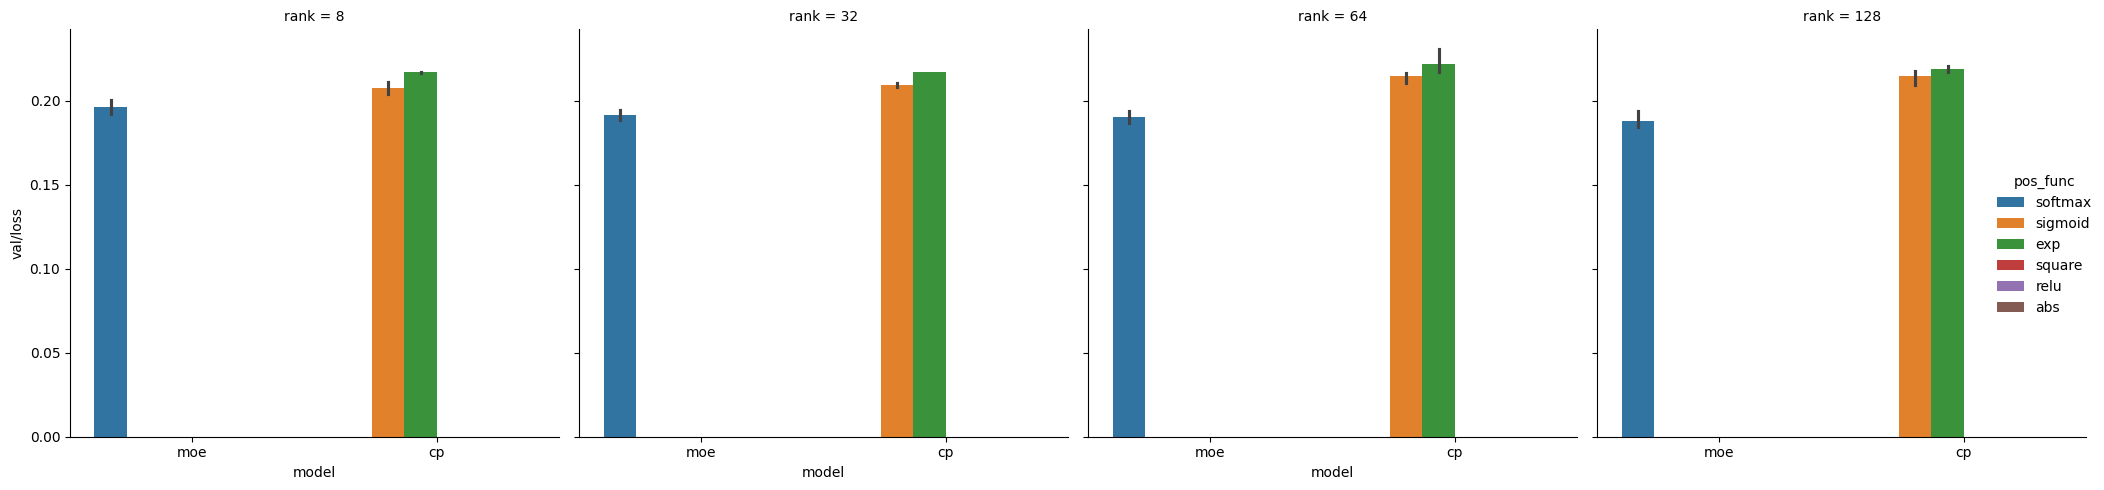

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter out rank=10
df = df[df['rank'] != 10]

plt.figure(figsize=(10,5))
g = sns.catplot(
    data=df, 
    x="model",
    y="val/loss", 
    hue="pos_func", 
    col="rank", 
    # col_wrap=3, 
    kind="bar"
)
# g._legend.remove()
plt.ylabel(r"$\min \, \mathcal{L}_{\mathrm{eval}}$")
plt.xlabel("")
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=24, title_fontsize=24, loc='upper left', bbox_to_anchor=(1,1))
# plt.legend([], [], frameon=False)
plt.tight_layout(); plt.show()

In [4]:
pd.DataFrame(rows)

,lr,rank,model,epochs,pos_func,batch_size,max_samples,num_gen_images,val/loss
0,0.001,10,cp,5,abs,32,None,10,NaN
1,0.001,10,mps,5,abs,32,None,10,NaN
2,0.001,10,moe,5,abs,32,None,10,NaN


### Qualitative evaluation of MPS and CP solutions

In [ ]:
import wandb, numpy as np, pandas as pd

api = wandb.Api()
PROJECT = "marawan-gamal/mnist-mtp"
KEY = "val/loss"

rows = []

for run in api.runs(PROJECT):
    vals = []
    for row in run.scan_history(keys=[KEY], page_size=10000):
        v = row.get(KEY)
        if isinstance(v, (int, float)):
            vals.append(float(v))
        elif isinstance(v, str):
            try:
                vals.append(float(v))
            except ValueError:
                pass
    min_val_loss = np.min(vals) if vals else float("nan")
    rows.append({
        "model": run.config["model"],
        "pos_func": run.config["pos_func"],
        "rank": run.config["rank"],
        "val/loss": min_val_loss,
        "run_id": run.id,
        "run_name": run.name,
    })

df = pd.DataFrame(rows)

# Renaming
# moe all pos_funcs to softmax
df.loc[df['model'] == 'moe', 'pos_func'] = 'softmax'

# For each model, find the run id with the lowest eval/loss and report it
best_runs = df.loc[df.groupby('model')["val/loss"].idxmin()][["model", "run_id", "run_name", "val/loss"]]
print("Best run id and name for each model (with lowest val/loss):")
print(best_runs)


Best run id and name for each model (with lowest val/loss):
   model    run_id                                 run_name  val/loss
9     cp  j3bzzj1s  mcp_e5_l0001_b32_r64_psigmoid_n10_mNone  0.216370
15   moe  vzycfc2s     mmoe_e5_l0001_b32_r64_pexp_n10_mNone  0.198867
1    mps  jcb95fpv     mmps_e5_l0001_b32_r10_pabs_n10_mNone  0.144189


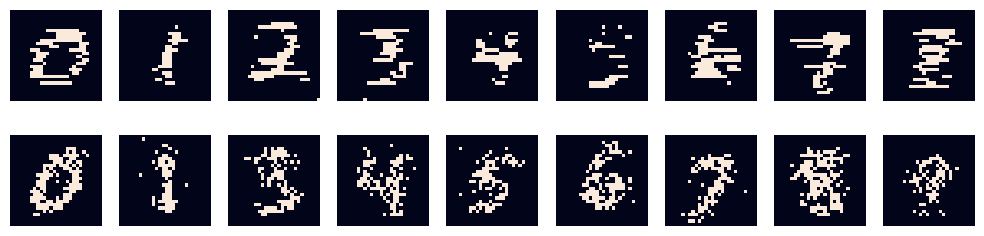

In [121]:
import wandb, PIL.Image, matplotlib.pyplot as plt

PROJECT = "marawan-gamal/mnist-mtp"
run_ids = ["jcb95fpv", "vzycfc2s"]  # put both run IDs here

fig, axes = plt.subplots(2, 9, figsize=(10, 3))

imgs = []
for run_id in run_ids:
    run = wandb.Api().run(f"{PROJECT}/{run_id}")

    hist = run.history(keys=["generated_images"], pandas=False)
    last_row = [row for row in hist if "generated_images" in row][-1]
    filenames =last_row["generated_images"]['filenames']
    files = [f for f in run.files() if "generated_images" in f.name][-9:]
    sorted_files = sorted(files, key=lambda f: filenames.index(f.name))

    for file in sorted_files:
        # print(f"file: {file}")
        img = PIL.Image.open(file.download(replace=True).name)
        imgs.append(img)

# plot all 9 images
for ax, img in zip(axes.ravel(), imgs):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


[<File media/images/generated_images_9379_e74f5198b747df9cc61c.png (image/png) 157.0B>,
 <File media/images/generated_images_9379_6a290c5d428dca7b28ae.png (image/png) 128.0B>,
 <File media/images/generated_images_9379_7d6dd3dfc56f7299edbf.png (image/png) 150.0B>,
 <File media/images/generated_images_9379_6e276b69e2bd44cba13c.png (image/png) 148.0B>,
 <File media/images/generated_images_9379_1a96872b68cefab4d841.png (image/png) 142.0B>,
 <File media/images/generated_images_9379_201b8173deacfd3db59f.png (image/png) 123.0B>,
 <File media/images/generated_images_9379_8fe1684aee2668f56704.png (image/png) 150.0B>,
 <File media/images/generated_images_9379_69862de47aa275604b90.png (image/png) 146.0B>,
 <File media/images/generated_images_9379_3454d832b27ad7d3d480.png (image/png) 145.0B>]

### Top MNIST

100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


,model,pos_func,rank,val/loss,horizon,name,lr
36,mps,exp,8,0.139029,784,mmps_e50_l0001_b32_r8_pexp_nNone_n10_mNone_sFalse,0.0010
13,mps,abs,8,0.140247,784,mmps_e20_l0001_b32_r8_pabs_nNone_n10_mNone_sFalse,0.0010
26,mps,abs,16,0.140270,784,mmps_e20_l0001_b32_r16_pabs_nNone_n10_mNone_sF...,0.0010
16,mps,abs,8,0.140360,784,mmps_e20_l00005_b32_r8_pabs_nNone_n10_mNone_sF...,0.0005
29,mps,abs,8,0.140590,784,mmps_e20_l0001_b32_r8_pabs_nNone_n10_mNone_sFalse,0.0010
27,mps,abs,32,0.140939,784,mmps_e20_l0001_b32_r32_pabs_nNone_n10_mNone_sF...,0.0010
12,mps,abs,4,0.141376,784,mmps_e20_l0001_b32_r4_pabs_nNone_n10_mNone_sFalse,0.0010
15,mps,abs,4,0.141547,784,mmps_e20_l00005_b32_r4_pabs_nNone_n10_mNone_sF...,0.0005
39,mps,exp,8,0.143755,784,mmps_e50_l00005_b32_r8_pexp_nNone_n10_mNone_sF...,0.0005
19,mps,abs,8,0.145847,784,mmps_e20_l00001_b32_r8_pabs_nNone_n10_mNone_sF...,0.0001


In [10]:
# Group by model and report the lowest val/loss for each model
df = df.loc[df.groupby(["model", "pos_func"])["val/loss"].idxmin()].reset_index(drop=True)
df

,model,pos_func,rank,val/loss,horizon,name
0,cp,abs,8,171.064067,784,mcp_e10_l0001_b32_r8_pabs_nNone_n10_mNone
1,moe,abs,64,133.263438,784,mmoe_e20_l0001_b32_r64_pabs_nNone_n10_mNone_sF...
2,mps,abs,8,109.953414,784,mmps_e20_l0001_b32_r8_pabs_nNone_n10_mNone_sFalse
3,mps,exp,8,108.998561,784,mmps_e50_l0001_b32_r8_pexp_nNone_n10_mNone_sFalse
4,mps,rbf,8,503.928767,784,mmps_e50_l0001_b32_r8_prbf_nNone_n10_mNone_sFalse
5,mps,sigmoid,8,115.910169,784,mmps_e50_l0001_b32_r8_psigmoid_nNone_n10_mNone...
6,mps,square,8,169.808989,784,mmps_e50_l00005_b32_r8_psquare_nNone_n10_mNone...


## Results Shakespeare

In [ ]:
import wandb, numpy as np, pandas as pd

api = wandb.Api()
PROJECT = "marawan-gamal/nanogpt-shakespeare"
KEY = "val/loss"

rows = []

for run in api.runs(PROJECT):
    vals = []
    for row in run.scan_history(keys=[KEY], page_size=10000):
        v = row.get(KEY)
        if isinstance(v, (int, float)):
            vals.append(float(v))
        elif isinstance(v, str):
            try:
                vals.append(float(v))
            except ValueError:
                pass
    min_val_loss = np.min(vals) if vals else float("nan")
    rows.append({
        "lm_head": run.config["lm_head"],
        "lm_head_pos_func": run.config["lm_head_pos_func"],
        "lm_head_rank": run.config["lm_head_rank"],
        "val/loss": min_val_loss,
    })

df = pd.DataFrame(rows)

# Renaming
# moe all pos_funcs to softmax
df.loc[df['lm_head'] == 'moe', 'pos_func'] = 'softmax'
print(df)


        lm_head lm_head_pos_func  lm_head_rank  val/loss pos_func
0           stp          sigmoid             1  0.445155      NaN
1           stp          sigmoid             1  0.497872      NaN
2           stp          sigmoid             1  0.491259      NaN
3   moe_decoder          sigmoid             8  1.644447      NaN
4   moe_decoder          sigmoid            32  1.480135      NaN
5   moe_decoder          sigmoid            32  2.322609      NaN
6   moe_decoder          sigmoid            32  1.236542      NaN
7   moe_decoder          sigmoid            32       NaN      NaN
8   moe_decoder          sigmoid            32       NaN      NaN
9   moe_decoder          sigmoid            32  2.332254      NaN
10  moe_decoder          sigmoid            64  1.102499      NaN
11  moe_decoder          sigmoid           128  2.871729      NaN


<Figure size 1000x500 with 0 Axes>

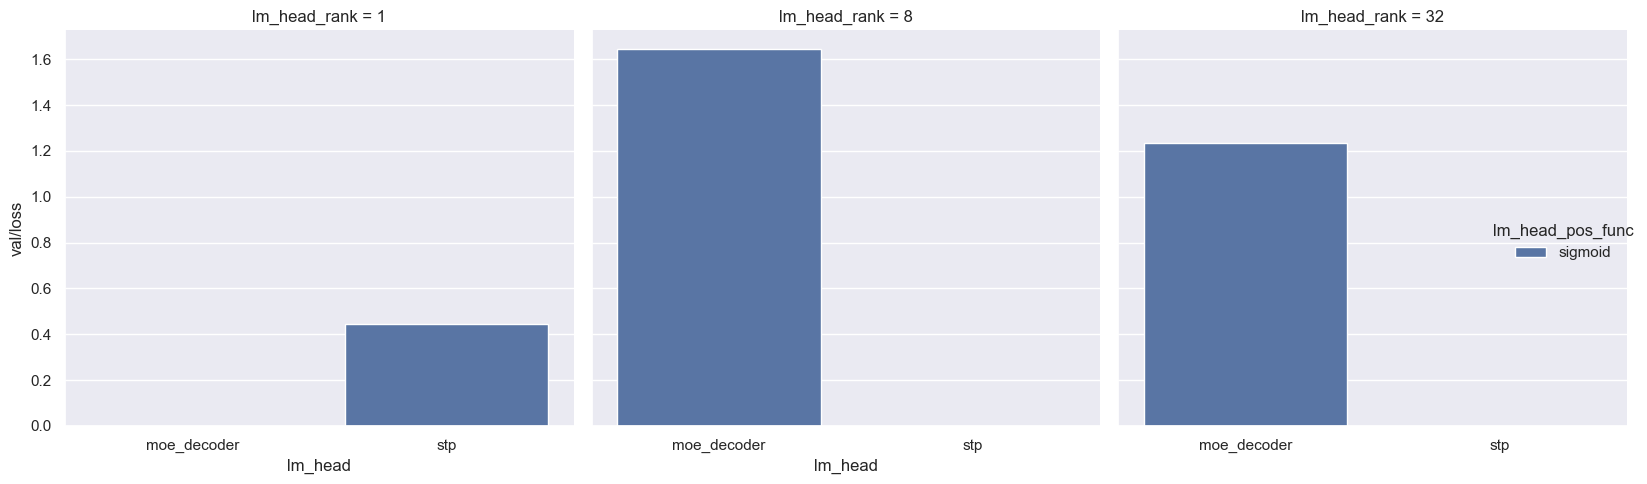

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# group by lm_head, lm_head_pos_func, lm_head_rank and take the min val/loss
df = df.groupby(['lm_head', 'lm_head_pos_func', 'lm_head_rank']).min().reset_index()

plt.figure(figsize=(10,5))
g = sns.catplot(
    data=df, 
    x="lm_head",
    y="val/loss", 
    hue="lm_head_pos_func", 
    col="lm_head_rank", 
    # col_wrap=3, 
    kind="bar"
)
# g._legend.remove()
plt.ylabel(r"$\min \, \mathcal{L}_{\mathrm{eval}}$")
plt.xlabel("")
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=24, title_fontsize=24, loc='upper left', bbox_to_anchor=(1,1))
# plt.legend([], [], frameon=False)
plt.tight_layout(); plt.show()

## Results UCLA

In [30]:
import wandb, numpy as np, pandas as pd
from tqdm import tqdm

api = wandb.Api()
PROJECT = "marawan-gamal/ctn-ucla"


def get_min_val(run, key='val/loss'):
    vals = []
    for row in run.scan_history(keys=[key], page_size=10000):
        v = row.get(key)
        if isinstance(v, (int, float)):
            vals.append(float(v))
        elif isinstance(v, str):
            try:
                vals.append(float(v))
            except ValueError:
                pass
    return np.min(vals) if vals else float("nan")
    
rows = []
for run in tqdm(api.runs(PROJECT)):
    min_val_loss = get_min_val(run, key='val/loss')
    horizon = get_min_val(run, key='horizon')
    rows.append({
        "model": run.config["model"],
        "dataset": run.config["dataset"],
        "pos_func": run.config["pos_func"],
        "rank": run.config["rank"],
        "val/loss": min_val_loss,
        "horizon": horizon,
        "name": run.name,
    })

df = pd.DataFrame(rows)
df['val/loss'] = df['val/loss'] * df['horizon']
df


100%|██████████| 18/18 [00:57<00:00,  3.21s/it]


,model,dataset,pos_func,rank,val/loss,horizon,name
0,moe,nltcs,abs,8,NaN,NaN,mmoe_e5_l0001_b32_r8_pabs_n10_mNone_sFalse_dnltcs
1,moe,msnbc,abs,8,NaN,NaN,mmoe_e5_l0001_b32_r8_pabs_n10_mNone_sFalse_dmsnbc
2,moe,msnbc,abs,8,3.196062,8.0,mmoe_e5_l0001_b32_r8_pabs_n10_mNone_sFalse_dmsnbc
3,moe,baudio,abs,8,19.832567,50.0,mmoe_e10_l0001_b32_r8_pabs_n10_mNone_sFalse_db...
4,moe,msnbc,abs,32,3.083158,8.0,mmoe_e10_l0001_b32_r32_pabs_n10_mNone_sFalse_d...
5,moe,nltcs,abs,8,2.943507,8.0,mmoe_e10_l0001_b32_r8_pabs_n10_mNone_sFalse_dn...
6,moe,msnbc,abs,8,3.188864,8.0,mmoe_e10_l0001_b32_r8_pabs_n10_mNone_sFalse_dm...
7,moe,nltcs,abs,32,2.935711,8.0,mmoe_e10_l0001_b32_r32_pabs_n10_mNone_sFalse_d...
8,moe,plants,abs,8,5.951354,34.0,mmoe_e10_l0001_b32_r8_pabs_n10_mNone_sFalse_dp...
9,moe,kdd,abs,32,1.103312,32.0,mmoe_e10_l0001_b32_r32_pabs_n10_mNone_sFalse_dkdd


In [28]:
# For each (model, dataset), find the row with the minimum val/loss, and keep the rest of the columns from that row
idx = df.groupby(['model', 'dataset'])['val/loss'].idxmin()
df_grouped = df.loc[idx].reset_index(drop=True)
df_grouped

,model,dataset,pos_func,rank,val/loss,horizon,name
0,moe,baudio,abs,8,19.832567,50.0,mmoe_e10_l0001_b32_r8_pabs_n10_mNone_sFalse_db...
1,moe,kdd,abs,8,1.096494,32.0,mmoe_e10_l0001_b32_r8_pabs_n10_mNone_sFalse_dkdd
2,moe,msnbc,abs,64,3.064332,8.0,mmoe_e10_l0001_b32_r64_pabs_n10_mNone_sFalse_d...
3,moe,nltcs,abs,64,2.933987,8.0,mmoe_e10_l0001_b32_r64_pabs_n10_mNone_sFalse_d...
4,moe,plants,abs,32,5.866731,34.0,mmoe_e10_l0001_b32_r32_pabs_n10_mNone_sFalse_d...


In [29]:
import io

# Parse the CSPN results string into a pandas DataFrame
cspn_results = """Dataset DACL CSPN DACL CSPN
Nltcs -2.770 -2.795 -1.255 -1.256
Msnbc -2.918 -3.165 -1.557 -1.684
KDD -0.998 -1.023 -0.386 -0.397
Plants -4.655 -4.720 -1.812 -1.683
Audio -18.958 -18.543 -7.337 -7.110
Jester -24.830 -24.543 -9.998 -9.830
Netflix -26.245 -25.914 -10.482 -10.351
Accidents -9.718 -11.587 -3.493 -4.045
Retail -4.825 -5.600 -1.687 -1.654
Pumsb. -6.363 -7.383 -2.594 -2.618
Dna -34.737 -38.243 -12.116 -11.895
Kosarek -5.053 -5.527 -2.549 -2.397
MSWeb -5.653 -6.686 -1.333 -1.335
Book -16.801 -10.653 -6.817 -3.191
EachMovie -25.325 -18.130 -9.403 -4.579
WebKB -72.072 -18.542 -28.087 -2.623
Reuters-52 -41.544 -15.736 -17.143 -3.878
20News -76.063 -35.900 -27.918 -4.984
Bbc -118.684 -47.138 -44.811 -2.996
Ad -4.893 -6.290 -1.370 -1.030
"""

header = ["Dataset", "DACL (50%)", "CSPN (50%)", "DACL (100%)", "CSPN (100%)"]

import pandas as pd

cspn_df = pd.read_csv(
    io.StringIO(
        "\n".join(
            [cspn_results.splitlines()[0]] +
            [line for line in cspn_results.splitlines()[1:] if line.strip()]
        )
    ),
    sep='\s+',
    header=0,
    names=header
)

# drop the 100% cols
cspn_df = cspn_df.drop(columns=['DACL (100%)', 'CSPN (100%)'])

# Prepare the other df: get dataset and val/loss, and normalize dataset names for matching
df_for_merge = df_grouped[['dataset', 'val/loss']].copy()
df_for_merge['dataset_norm'] = df_for_merge['dataset'].str.lower().str.replace('.', '', regex=False)

# Prepare cspn_df: normalize Dataset names for matching
cspn_df['dataset_norm'] = cspn_df['Dataset'].str.lower().str.replace('.', '', regex=False)

# Merge on normalized dataset names, keeping all cspn_df columns and only val/loss from df
merged = pd.merge(
    cspn_df,
    df_for_merge[['dataset_norm', 'val/loss']],
    how='left',
    on='dataset_norm'
)

# Drop the helper column
merged = merged.drop(columns=['dataset_norm'])

merged

,Dataset,DACL (50%),CSPN (50%),val/loss
0,Nltcs,-2.770,-2.795,2.933987
1,Msnbc,-2.918,-3.165,3.064332
2,KDD,-0.998,-1.023,1.096494
3,Plants,-4.655,-4.720,5.866731
4,Audio,-18.958,-18.543,NaN
5,Jester,-24.830,-24.543,NaN
6,Netflix,-26.245,-25.914,NaN
7,Accidents,-9.718,-11.587,NaN
8,Retail,-4.825,-5.600,NaN
9,Pumsb.,-6.363,-7.383,NaN
